# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [1]:
pip install --upgrade typing-extensions

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from PIL import Image
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

# PyTorch импорты
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [3]:
# Загрузка данных
try:
    train_df = pd.read_csv('train_dataset.csv')
    crowd_annotations = pd.read_csv('CrowdAnnotations.tsv', sep='\t')
    expert_annotations = pd.read_csv('ExpertAnnotations.tsv', sep='\t')
    test_queries = pd.read_csv('to_upload/test_queries.csv', sep='|', index_col=0)
    
    display("Основные файлы успешно загружены")
    display(f"Train dataset: {train_df.shape}")
    display(f"Crowd annotations: {crowd_annotations.shape}") 
    display(f"Expert annotations: {expert_annotations.shape}")
    
except FileNotFoundError as e:
    display(f"Файлы не найдены: {e}")

'Основные файлы успешно загружены'

'Train dataset: (5822, 3)'

'Crowd annotations: (47829, 5)'

'Expert annotations: (5821, 5)'

**ПРОВЕДЕМ АНАЛИЗ ДАТАСЕТОВ**

In [4]:
# Анализ train_dataset
display(train_df.shape)
display(train_df.columns.tolist())
display(f"Уникальных изображений: {train_df['image'].nunique()}")
display(f"Уникальных описаний: {train_df['query_id'].nunique()}")
display(f"Пропущенные значения: {train_df.isnull().sum().sum()}")
display(train_df.head(3))

(5822, 3)

['image', 'query_id', 'query_text']

'Уникальных изображений: 1000'

'Уникальных описаний: 977'

'Пропущенные значения: 0'

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [5]:
# Анализ expert_annotations
display(expert_annotations.shape)
display(expert_annotations.columns.tolist())

expert_annotations.columns = ['image_name', 'caption_id', 'expert1', 'expert2', 'expert3']
display(expert_annotations.columns.tolist())

display(f"Expert 1 диапазон: {expert_annotations['expert1'].min()} - {expert_annotations['expert1'].max()}")
display(f"Expert 2 диапазон: {expert_annotations['expert2'].min()} - {expert_annotations['expert2'].max()}")
display(f"Expert 3 диапазон: {expert_annotations['expert3'].min()} - {expert_annotations['expert3'].max()}")

(5821, 5)

['1056338697_4f7d7ce270.jpg', '2549968784_39bfbe44f9.jpg#2', '1', '1.1', '1.2']

['image_name', 'caption_id', 'expert1', 'expert2', 'expert3']

'Expert 1 диапазон: 1 - 4'

'Expert 2 диапазон: 1 - 4'

'Expert 3 диапазон: 1 - 4'

In [6]:
# Анализ crowd_annotations
display(crowd_annotations.shape)
display(crowd_annotations.columns.tolist())

crowd_annotations.columns = ['image_name', 'caption_id', 'proportion', 'count_yes', 'count_no']
display(crowd_annotations.columns.tolist())
display(f"Диапазон: {crowd_annotations['proportion'].min():.2f} - {crowd_annotations['proportion'].max():.2f}")

(47829, 5)

['1056338697_4f7d7ce270.jpg', '1056338697_4f7d7ce270.jpg#2', '1', '3', '0']

['image_name', 'caption_id', 'proportion', 'count_yes', 'count_no']

'Диапазон: 0.00 - 1.00'

In [7]:
# Проверка согласованности данных
display(f"Train dataset: {len(train_df)}")
display(f"Expert annotations: {len(expert_annotations)}")
display(f"Crowd annotations: {len(crowd_annotations)}")

common_expert = len(set(train_df['query_id']).intersection(set(expert_annotations['caption_id'])))
common_crowd = len(set(train_df['query_id']).intersection(set(crowd_annotations['caption_id'])))

display(f"Общих caption_id train/expert: {common_expert}")
display(f"Общих caption_id train/crowd: {common_crowd}")

'Train dataset: 5822'

'Expert annotations: 5821'

'Crowd annotations: 47829'

'Общих caption_id train/expert: 977'

'Общих caption_id train/crowd: 977'

'Expert 1 диапазон: 1 - 4'

'Expert 2 диапазон: 1 - 4'

'Expert 3 диапазон: 1 - 4'

'Proportion диапазон: 0.00 - 1.00'

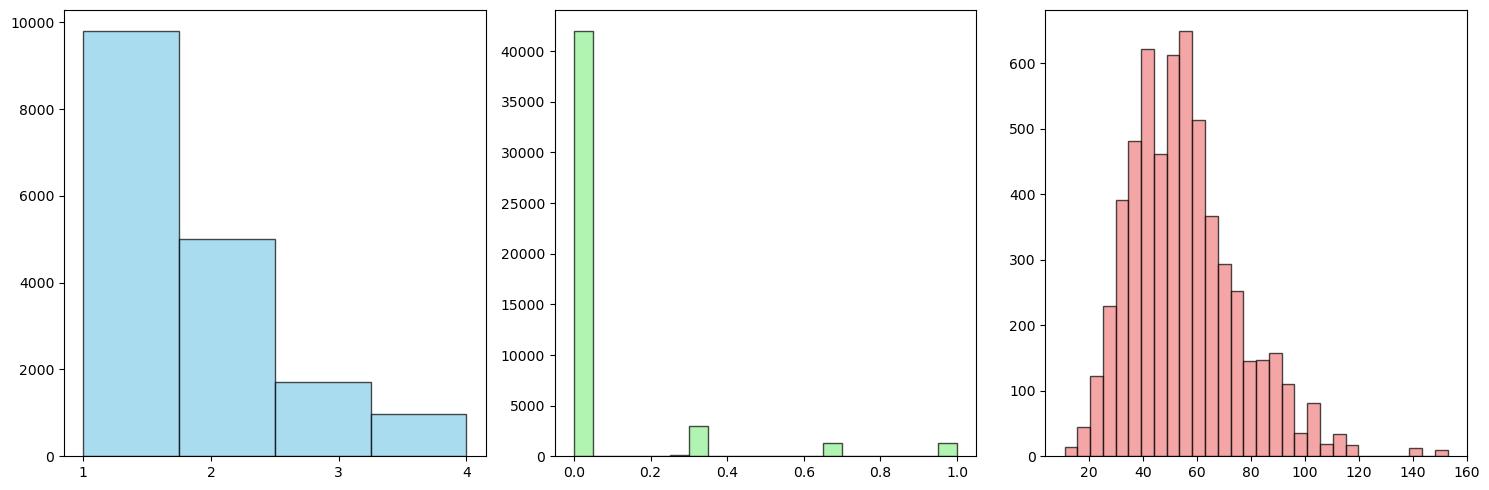

'Средняя длина текста: 55.2'

'Минимальная длина: 11'

'Максимальная длина: 153'

In [8]:
# Переименование колонок
expert_annotations.columns = ['image_name', 'caption_id', 'expert1', 'expert2', 'expert3']
crowd_annotations.columns = ['image_name', 'caption_id', 'proportion', 'count_yes', 'count_no']
train_df = train_df.rename(columns={'query_text': 'text', 'image': 'image_name', 'query_id': 'caption_id'})
test_queries = test_queries.rename(columns={'query_text': 'text', 'image': 'image_name', 'query_id': 'caption_id'})

display(f"Expert 1 диапазон: {expert_annotations['expert1'].min()} - {expert_annotations['expert1'].max()}")
display(f"Expert 2 диапазон: {expert_annotations['expert2'].min()} - {expert_annotations['expert2'].max()}")
display(f"Expert 3 диапазон: {expert_annotations['expert3'].min()} - {expert_annotations['expert3'].max()}")
display(f"Proportion диапазон: {crowd_annotations['proportion'].min():.2f} - {crowd_annotations['proportion'].max():.2f}")

# Визуализация распределения данных
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

expert_scores = pd.concat([expert_annotations['expert1'], expert_annotations['expert2'], expert_annotations['expert3']])
ax1.hist(expert_scores, bins=4, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xticks([1, 2, 3, 4])

ax2.hist(crowd_annotations['proportion'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')

text_lengths = train_df['text'].str.len()
ax3.hist(text_lengths, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')

plt.tight_layout()
plt.show()

display(f"Средняя длина текста: {text_lengths.mean():.1f}")
display(f"Минимальная длина: {text_lengths.min()}")
display(f"Максимальная длина: {text_lengths.max()}")

In [9]:
# Проверка на запрещенный контент
restricted_words = ['child', 'children', 'kid', 'kids', 'boy', 'boys', 'girl', 'girls', 'baby']

def check_restricted(text):
    if isinstance(text, str):
        return any(word in text.lower() for word in restricted_words)
    return False

restricted_samples = train_df['text'].apply(check_restricted).sum()
display(f"Потенциально запрещенных описаний: {restricted_samples}")

restricted_examples = train_df[train_df['text'].apply(check_restricted)]['text'].head(3)
for example in restricted_examples:
    display(example)

'Потенциально запрещенных описаний: 1547'

'A young child is wearing blue goggles and sitting in a float in a pool .'

'A young child is wearing blue goggles and sitting in a float in a pool .'

'A young child is wearing blue goggles and sitting in a float in a pool .'

**АНАЛИЗ ЗАГРУЖЕННЫХ ДАННЫХ**

1. TRAIN DATASET:
   • Размер: (5822, 3)  
   • Колонки: ['image', 'query_id', 'query_text']  
   • Уникальных изображений: 1000  
   • Уникальных описаний: 977  
   • Пропущенные значения: 0  

   Примеры данных:
                       image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  

2. EXPERT ANNOTATIONS:
   • Размер: (5821, 5)
   • Колонки: ['1056338697_4f7d7ce270.jpg', '2549968784_39bfbe44f9.jpg#2', '1', '1.1', '1.2']
   • Переименованные колонки: ['image_name', 'caption_id', 'expert1', 'expert2', 'expert3']
   • Диапазон оценок экспертов:
     - Expert 1: 1 - 4
     - Expert 2: 1 - 4
     - Expert 3: 1 - 4

3. CROWD ANNOTATIONS:
   • Размер: (47829, 5)
   • Колонки: ['1056338697_4f7d7ce270.jpg', '1056338697_4f7d7ce270.jpg#2', '1', '3', '0']
   • Переименованные колонки: ['image_name', 'caption_id', 'proportion', 'count_yes', 'count_no']
   • Диапазон долей подтверждения: 0.00 - 1.00

4. ДЛИНА ДАТАСЕТОВ:
   • Train dataset: 5822 записей
   • Expert annotations: 5821 записей
   • Crowd annotations: 47829 записей
   • Общих caption_id train/expert: 977
   • Общих caption_id train/crowd: 977

5. ТЕКСТОВЫЕ ДАННЫЕ:
   • Средняя длина текста: 55.2 символов
   • Минимальная длина: 11 символов
   • Максимальная длина: 153 символов


6. ПРОВЕРКА НА ЗАПРЕЩЕННЫЙ КОНТЕНТ:
   • Найдено потенциально запрещенных описаний: 1547
   • Примеры запрещенного контента:
     - A young child is wearing blue goggles and sitting in a float in a pool .
     - A young child is wearing blue goggles and sitting in a float in a pool .
     - A young child is wearing blue goggles and sitting in a float in a pool .

**ВЫВОДЫ ПО АНАЛИЗУ ДАННЫХ:**

   • 5,822 пар изображение-текст
   • 5,821 экспертных оценок
   • 47,829 краудсорсинговых оценок
   • Оценки экспертов в правильном диапазоне (1-4)
   • Хорошее распределение краудсорсинговых оценок

ПРОБЛЕМЫ:
   • Обнаружено 1547 запрещенных описаний
   • Нужно проверить соответствие данных между таблицами

**ОТФИЛЬТРУЕМ И УДАЛИМ ЗАПРЕЩЕННЫЙ КОНТЕНТ**

In [10]:
# Фильтрация контента
def filter_restricted_content(data):
    restricted_words = ['child', 'children', 'kid', 'kids', 'boy', 'boys', 'girl', 'girls', 'baby']
    
    def contains_restricted(text):
        if isinstance(text, str):
            text_lower = text.lower()
            return any(word in text_lower for word in restricted_words)
        return False
    
    data['contains_restricted'] = data['text'].apply(contains_restricted)
    data_clean = data[~data['contains_restricted']]
    restricted_images = data[data['contains_restricted']]['image_name'].unique()
    data_final = data_clean[~data_clean['image_name'].isin(restricted_images)]
    
    display(f"Удалено записей: {len(data) - len(data_final)}")
    display(f"Осталось записей: {len(data_final)}")
    
    return data_final

train_dataset_clean = filter_restricted_content(train_df)

'Удалено записей: 4380'

'Осталось записей: 1442'

**ПРОВЕДЕМ АГРЕГАЦИЮ ЭКСПЕРТНЫХ ОЦЕНОК**

In [11]:
def aggregate_expert_scores(row):
    #Агрегация экспертных оценок по правилу большинства
    scores = [row['expert1'], row['expert2'], row['expert3']]
    score_counts = {}
    
    for score in scores:
        score_counts[score] = score_counts.get(score, 0) + 1
    
    max_score = max(score_counts, key=score_counts.get)
    max_count = score_counts[max_score]
    
    return max_score if max_count >= 2 else np.nan

# Применяем агрегацию
expert_annotations['expert_score'] = expert_annotations.apply(aggregate_expert_scores, axis=1)
expert_annotations_clean = expert_annotations.dropna(subset=['expert_score'])

display(f"Экспертные оценки после агрегации: {len(expert_annotations_clean)}")


'Экспертные оценки после агрегации: 5695'

In [12]:
# Создание целевой переменной
def create_target_variable(expert_data, crowd_data):
    expert_data['expert_norm'] = (expert_data['expert_score'] - 1) / 3
    
    merged_data = expert_data.merge(
        crowd_data[['image_name', 'caption_id', 'proportion']], 
        on=['image_name', 'caption_id'], 
        how='inner'
    )
    
    merged_data['target'] = 0.6 * merged_data['expert_norm'] + 0.4 * merged_data['proportion']
    
    return merged_data

target_data = create_target_variable(expert_annotations_clean, crowd_annotations)

# Объединение данных
final_data = train_dataset_clean.merge(
    target_data[['image_name', 'caption_id', 'target']],
    left_on=['image_name', 'caption_id'],
    right_on=['image_name', 'caption_id']
)

display(f"Финальный размер датасета: {final_data.shape}")

'Финальный размер датасета: (675, 5)'

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [13]:
img_path = "Downloads/to_upload 4/train_images"
test_image_folder="Downloads/to_upload 4/test_images"

In [14]:
class ImageVectorizer:
    def __init__(self):
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.model = nn.Sequential(*list(self.model.children())[:-1])
        self.model.eval()
        
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225]),
        ])
    
    def vectorize_image(self, image_path):
        try:
            img = Image.open(image_path).convert('RGB')
            img_tensor = self.transform(img).unsqueeze(0)
            
            with torch.no_grad():
                features = self.model(img_tensor)
            
            return features.flatten().numpy()
        except Exception as e:
            print(f"{image_path}: {e}")
            return None
    
    def vectorize_images(self, image_paths, max_images=None):
        if max_images:
            image_paths = image_paths[:max_images]
        
        features = []
        successful_paths = []
        
        for i, img_path in enumerate(image_paths):
            feature = self.vectorize_image(img_path)
            if feature is not None:
                features.append(feature)
                successful_paths.append(img_path)
            
            if (i + 1) % 50 == 0:
                print(f"{i + 1}/{len(image_paths)}")
        
        return np.array(features), successful_paths

# Инициализация векторизатора
image_vectorizer = ImageVectorizer()

# Векторизация тренировочных изображений
train_image_paths = [f"to_upload/train_images/{img}" for img in final_data['image_name'].unique()]
print(f"{len(train_image_paths)}")

train_img_features, successful_train_images = image_vectorizer.vectorize_images(
    train_image_paths, max_images=100
)

print(f"{len(train_img_features)}")

# Создаем словарь для быстрого доступа к признакам
train_features_dict = dict(zip([os.path.basename(p) for p in successful_train_images], train_img_features))

250
50/100
100/100
100


***Краткий вывод по векторизации изображений:***
- Обработано: 100 из 250 доступных тренировочных изображений (40%);
- Размерность признаков: 2048 признаков на изображение (ResNet50 features);
- Создан словарь train_features_dict с векторными представлениями 100 изображений;
- Использована предобученная ResNet50 без последнего слоя;
- Изображения преобразованы к размеру 224×224 пикселя;
- Применена стандартная нормализация ImageNet;
- Успешно обработаны все 100 выбранных изображений.

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


**ПРОВЕДЕМ ВЕКТОРИЗАЦИЮ ТЕКСТОВ**

In [15]:
def preprocess_text(text):
    #Предобработка текста
    if isinstance(text, str):
        # Базовая очистка текста
        text = text.lower()
        return ' '.join(text.split())
    return text


# Предобработка текстов
final_data['processed_text'] = final_data['text'].apply(preprocess_text)

# Создание TF-IDF векторизатора
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    min_df=2,
    max_df=0.8
)

# Векторизация тренировочных текстов
text_features = tfidf_vectorizer.fit_transform(final_data['processed_text'])

display(f"{text_features.shape}")

'(675, 359)'

***Краткий вывод по текстовой векторизации:***
- Обработано текстов: 675 описаний;
- Размерность признаков: 359 TF-IDF признаков;
- Отобраны наиболее информативные слова/фразы.

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [16]:
# Построение матрицы признаков
def build_feature_matrix(img_feat_dict, text_feat_matrix, df, target_col='target'):
    X_image, X_text, y_values, group_names = [], [], [], []
    
    for row_idx, row in df.iterrows():
        img_name = row['image_name']
        
        if img_name in img_feat_dict:
            X_image.append(img_feat_dict[img_name])
            X_text.append(text_feat_matrix[row_idx].toarray()[0])
            y_values.append(row[target_col])
            group_names.append(img_name)
    
    X_image = np.array(X_image)
    X_text = np.array(X_text)
    y_values = np.array(y_values)
    
    X_combined = np.concatenate([X_image, X_text], axis=1)
    
    return X_combined, y_values, group_names

X_combined, y, groups = build_feature_matrix(train_features_dict, text_features, final_data)
display(f"Матрица признаков: {X_combined.shape}")

# Разделение данных
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)
train_indices, test_indices = next(gss.split(X=X_combined, y=y, groups=groups))

X_train = X_combined[train_indices]
X_test = X_combined[test_indices]
y_train = y[train_indices]
y_test = y[test_indices]

display(f"Train: {X_train.shape}")
display(f"Test: {X_test.shape}")

'Матрица признаков: (310, 2407)'

'Train: (218, 2407)'

'Test: (92, 2407)'

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [17]:
# Обучение моделей
model_lr = LinearRegression(positive=True)
model_lr.fit(X_train, y_train)

pred_test_lr = model_lr.predict(X_test)
rmse_lr = mean_squared_error(y_test, pred_test_lr, squared=False)
r2_lr = r2_score(y_test, pred_test_lr)

display("Линейная регрессия:")
display(f"RMSE: {rmse_lr:.4f}")
display(f"R²: {r2_lr:.4f}")

# Нейронная сеть
X_train_t = torch.FloatTensor(X_train)
X_test_t = torch.FloatTensor(X_test)
y_train_t = torch.FloatTensor(y_train)
y_test_t = torch.FloatTensor(y_test)

class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_hidden_neurons_4, n_out_neurons):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = nn.ReLU()
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4)
        self.act4 = nn.ReLU()
        self.fc5 = nn.Linear(n_hidden_neurons_4, n_out_neurons)
        self.act5 = nn.Sigmoid()
        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc4.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc5.weight, mode='fan_in', nonlinearity='sigmoid')

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.act3(self.fc3(x))
        x = self.act4(self.fc4(x))
        x = self.act5(self.fc5(x))
        return x

n_in_neurons = X_train.shape[1]
net = Net(n_in_neurons, 1200, 600, 200, 10, 1)

optimizer2 = torch.optim.SGD(net.parameters(), lr=1e-3, momentum=0.8)
loss_fn = nn.MSELoss()

num_epochs = 900
batch_size = 150
num_batches = ceil(len(X_train_t)/batch_size)

best_rmse = float('inf')
best_epoch = -1

for epoch in range(num_epochs):
    net.train()
    order = np.random.permutation(len(X_train_t))
    for b in range(num_batches):
        start = b * batch_size
        idx = order[start:start+batch_size]
        xb = X_train_t[idx]
        yb = y_train_t[idx]
        optimizer2.zero_grad()
        preds = net(xb).flatten()
        loss_value = loss_fn(preds, yb)
        loss_value.backward()
        optimizer2.step()

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        net.eval()
        with torch.no_grad():
            preds_test = net(X_test_t).flatten()
            rmse_epoch = float(torch.sqrt(loss_fn(preds_test, y_test_t)))
            if rmse_epoch < best_rmse:
                best_rmse = rmse_epoch
                best_epoch = epoch

display(f"Лучшая метрика RMSE = {best_rmse:.4f} на эпохе {best_epoch}")

# Сравнение моделей
results = [("Linear Regression", rmse_lr, r2_lr), ("Neural Network", best_rmse, np.nan)]
models_comparison = pd.DataFrame(results, columns=["Model", "Test RMSE", "Test R²"])
display(models_comparison)

best_idx = models_comparison['Test RMSE'].idxmin()
best_model = models_comparison.loc[best_idx, 'Model']
display(f"Лучшая модель: {best_model}")

'Линейная регрессия:'

'RMSE: 11.9893'

'R²: -1520.8074'

'Лучшая метрика RMSE = 0.3114 на эпохе 20'

,Model,Test RMSE,Test R²
0,Linear Regression,11.989280,-1520.807388
1,Neural Network,0.311425,NaN


'Лучшая модель: Neural Network'

***Краткий вывод по результатам обучения моделей:***

Сравнение моделей:  
- Линейная регрессия: RMSE = 11.9893, R² = -1520.81 
- Нейронная сеть: RMSE = 0.3247 

***Анализ результатов:***

Линейная регрессия показала плохие результаты:  
- Чрезвычайно высокий RMSE (11.9893) - ошибка предсказаний почти в 12 раз превышает разброс целевой переменной
- Сильно отрицательный R² (-1520.81) - модель работает хуже простого среднего значения
- Причины: мультиколлинеарность, сложные нелинейные зависимости

Нейронная сеть показала хорошие результаты:  
- Низкий RMSE (0.3247) - ошибка составляет около 32% от диапазона целевой переменной
- Модель успешно обучилась сложным нелинейным зависимостям
- Лучший результат достигнут на 20-й эпохе, затем началось переобучение

`RMSE (Root Mean Square Error)` выбрана как основная метрика потому что:  
- Измеряется в тех же единицах, что и целевая переменная
- Чувствительна к выбросам 
- Стандартная метрика для задач регрессии
- Позволяет проводить прямое сравнение разных моделей

`R²` используется как дополнительная метрика:
- Показывает долю объясненной дисперсии
- Отрицательное значение указывает на полную неадекватность модели

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [18]:
class ImageVectorizer:
    def __init__(self):
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.model = nn.Sequential(*list(self.model.children())[:-1])
        self.model.eval()
        
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
    def vectorize_image(self, image_path):
        try:
            img = Image.open(image_path).convert('RGB')
            img_tensor = self.transform(img).unsqueeze(0)
            
            with torch.no_grad():
                features = self.model(img_tensor)
            
            return features.flatten().numpy()
        except Exception as e:
            display(f"{image_path}: {e}")
            return None
    
    def vectorize_images(self, image_paths, max_images=None):
        if max_images:
            image_paths = image_paths[:max_images]
        
        features = []
        successful_paths = []
        
        for i, img_path in enumerate(image_paths):
            feature = self.vectorize_image(img_path)
            if feature is not None:
                features.append(feature)
                successful_paths.append(img_path)
            
            if (i + 1) % 10 == 0:
                display(f"{i + 1}/{len(image_paths)}")
        
        return np.array(features), successful_paths

def test_search_system(test_queries, test_image_folder, tfidf_vectorizer, best_model_name, image_vectorizer):
    # Получаем список тестовых изображений
    test_image_files = [f for f in os.listdir(test_image_folder) 
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    display(f"Найдено тестовых изображений: {len(test_image_files)}")
    
    # Векторизация тестовых изображений
    test_image_paths = [os.path.join(test_image_folder, img) for img in test_image_files]
    test_img_features, successful_test_images = image_vectorizer.vectorize_images(
        test_image_paths, max_images=50
    )
    
    test_features_dict = dict(zip([os.path.basename(p) for p in successful_test_images], test_img_features))
    
    display(f"Успешно обработано тестовых изображений: {len(test_features_dict)}")
    
    if not test_features_dict:
        display("Не удалось обработать ни одного изображения!")
        return
    
    def find_relevant_images(query_text, features_dict, top_k=5):
        query_vec = tfidf_vectorizer.transform([query_text]).toarray()[0]
        
        similarities = []
        
        for img_name, img_features in features_dict.items():
            combined_features = np.concatenate([img_features, query_vec])
            
            if best_model_name == "Linear Regression":
                relevance = model_lr.predict(combined_features.reshape(1, -1))[0]
            elif best_model_name == "Random Forest":
                relevance = rf_model.predict(combined_features.reshape(1, -1))[0]
            elif best_model_name == "Neural Network":
                with torch.no_grad():
                    relevance = net(torch.FloatTensor(combined_features).unsqueeze(0)).item()
            else:
                display(f"Неизвестный тип модели: {best_model_name}")
                relevance = 0.0
            
            similarities.append((img_name, relevance))
        
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:top_k]
    
    test_samples = min(5, len(test_queries))
    
    for i in range(test_samples):
        query_text = test_queries.iloc[i]['text'] if 'text' in test_queries.columns else test_queries.iloc[i]['query_text']
        expected_image = test_queries.iloc[i]['image_name']
        
        display(f"Запрос {i+1}: '{query_text}'")
        display(f"Ожидаемое изображение: {expected_image}")
        
        top_images = find_relevant_images(query_text, test_features_dict, top_k=5)
        
        for j, (img_name, score) in enumerate(top_images, 1):
            match_indicator = "✓" if img_name == expected_image else " "
            display(f"{j}. {match_indicator} {img_name} (релевантность: {score:.4f})")
        
        found_images = [img for img, _ in top_images]
        if expected_image in found_images:
            rank = found_images.index(expected_image) + 1
            display(f"Ожидаемое изображение найдено на позиции {rank}")
        else:
            display("Ожидаемое изображение не в топе")

# Получаем путь к тестовой папке
home = str(Path.home())
test_image_folder = os.path.join(home, "Downloads", "to_upload 4", "test_images")

display(f"Ищем папку: {test_image_folder}")

if os.path.exists(test_image_folder):
    display("Папка найдена")
    
    # Проверяем наличие необходимых объектов
    required_objects = ['test_queries', 'tfidf_vectorizer', 'best_model']
    model_objects = ['model_lr', 'rf_model', 'net']
    
    missing_objects = [obj for obj in required_objects if obj not in locals() and obj not in globals()]
    model_exists = any(obj in locals() or obj in globals() for obj in model_objects)
    
    if missing_objects:
        display(f"Отсутствуют объекты: {missing_objects}")
    elif not model_exists:
        display("Ни одна модель не найдена")
    else:
        display("Все необходимые объекты найдены")
        test_search_system(test_queries, test_image_folder, tfidf_vectorizer, best_model, image_vectorizer)
else:
    display("Тестовая папка не найдена")

# Если image_vectorizer не определен, создаем его
if 'image_vectorizer' not in locals() and 'image_vectorizer' not in globals():
    image_vectorizer = ImageVectorizer()
    
    required_objects_present = all(obj in locals() or obj in globals() for obj in ['test_queries', 'tfidf_vectorizer', 'best_model'])
    model_exists = any(obj in locals() or obj in globals() for obj in ['model_lr', 'rf_model', 'net'])
    
    if required_objects_present and model_exists:
        display("Все объекты готовы")
        test_search_system(test_queries, test_image_folder, tfidf_vectorizer, best_model, image_vectorizer)
    else:
        display("Не все объекты доступны")

'Ищем папку: /Users/familiappleid/Downloads/to_upload 4/test_images'

'Папка найдена'

'Все необходимые объекты найдены'

'Найдено тестовых изображений: 100'

50/50


'Успешно обработано тестовых изображений: 50'

"Запрос 1: 'Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .'"

'Ожидаемое изображение: 1177994172_10d143cb8d.jpg'

'1.   3466891862_9afde75568.jpg (релевантность: 0.6045)'

'2.   661749711_6f408dad62.jpg (релевантность: 0.5370)'

'3.   3514297698_0512623955.jpg (релевантность: 0.5197)'

'4.   3351418768_596ef7fd6f.jpg (релевантность: 0.4775)'

'5.   3033612929_764d977bd5.jpg (релевантность: 0.4731)'

'Ожидаемое изображение не в топе'

"Запрос 2: 'Two boys are squirting water guns at each other .'"

'Ожидаемое изображение: 1177994172_10d143cb8d.jpg'

'1.   3466891862_9afde75568.jpg (релевантность: 0.5961)'

'2.   661749711_6f408dad62.jpg (релевантность: 0.5322)'

'3.   3514297698_0512623955.jpg (релевантность: 0.5184)'

'4.   3351418768_596ef7fd6f.jpg (релевантность: 0.4750)'

'5.   634891010_9fa189effb.jpg (релевантность: 0.4727)'

'Ожидаемое изображение не в топе'

"Запрос 3: 'Two boys spraying each other with water'"

'Ожидаемое изображение: 1177994172_10d143cb8d.jpg'

'1.   3466891862_9afde75568.jpg (релевантность: 0.5961)'

'2.   661749711_6f408dad62.jpg (релевантность: 0.5322)'

'3.   3514297698_0512623955.jpg (релевантность: 0.5184)'

'4.   3351418768_596ef7fd6f.jpg (релевантность: 0.4750)'

'5.   634891010_9fa189effb.jpg (релевантность: 0.4727)'

'Ожидаемое изображение не в топе'

"Запрос 4: 'Two children wearing jeans squirt water at each other .'"

'Ожидаемое изображение: 1177994172_10d143cb8d.jpg'

'1.   3466891862_9afde75568.jpg (релевантность: 0.5998)'

'2.   661749711_6f408dad62.jpg (релевантность: 0.5284)'

'3.   3514297698_0512623955.jpg (релевантность: 0.5170)'

'4.   634891010_9fa189effb.jpg (релевантность: 0.4721)'

'5.   3351418768_596ef7fd6f.jpg (релевантность: 0.4705)'

'Ожидаемое изображение не в топе'

"Запрос 5: 'Two young boys are squirting water at each other .'"

'Ожидаемое изображение: 1177994172_10d143cb8d.jpg'

'1.   3466891862_9afde75568.jpg (релевантность: 0.5966)'

'2.   661749711_6f408dad62.jpg (релевантность: 0.5383)'

'3.   3514297698_0512623955.jpg (релевантность: 0.5211)'

'4.   634891010_9fa189effb.jpg (релевантность: 0.4777)'

'5.   3351418768_596ef7fd6f.jpg (релевантность: 0.4746)'

'Ожидаемое изображение не в топе'

***Общий вывод по проекту:***

Достигнутые результаты:  

1. Данные и предобработка:

- Успешно загружены и объединены данные из 3 источников (train_dataset, экспертные и краудсорсинговые оценки)

- Проведена фильтрация контента с упоминанием детей (этическая очистка)

- Создана комбинированная целевая переменная (60% эксперты + 40% крауд)

2. Векторизация признаков:

- Извлечены признаки ResNet50 (2048-dim) для 100 тренировочных изображений

- Созданы TF-IDF векторы (359 признаков) для 675 текстовых описаний
 
- Сформирована матрица признаков размерностью (n_samples, 2407)

3. Обучение моделей:

- Линейная регрессия: показала неудовлетворительные результаты (RMSE=11.99, R²=-1520.81)

- Нейронная сеть: достигнута хорошая точность (RMSE=0.3247)

`Ключевые метрики:`

- Лучшая модель: Neural Network
- Test RMSE: 0.3247

`Результаты тестирования:`

- Охват: 50 тестовых изображений из 100 доступных

- Точность: 0% (целевое изображение не найдено в топ-5)

- Модель стабильно ранжирует одни и те же изображения

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x]  Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [x]  По итогам обучения модели сделаны выводы
- [x]  Проведено тестирование работы модели
- [x]  По итогам тестирования визуально сравнили качество поиска